Glass data

Prepaire a model for glass classification using KNN

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('pastel6')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

In [42]:
from google.colab import files


uploaded = files.upload()

Saving glass.csv to glass (2).csv


In [43]:
glass = pd.read_csv('glass.csv')

### Data Description:
Attributes:
- RI: refractive index
- Na: Sodium (unit measurement: weight percent in corresponding oxide, as are attributes 4-10)
- Mg: Magnesium
- AI: Aluminum
- Si: Silicon
- K:Potassium
- Ca: Calcium
- Ba: Barium
- Fe: Iron
- Type: Type of glass: (class attribute)
    1. building_windows_float_processed
    2. building_windows_non_float_processed
    3. vehicle_windows_float_processed
    4. vehicle_windows_non_float_processed (none in this database)
    5. containers
    6. tableware
    7. headlamps


In [44]:
glass.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [45]:
glass.shape

(214, 10)

Checking null values

In [46]:
glass.isna().sum()

RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64

In [47]:
glass.duplicated().sum()

1

1 duplicate record found, removing duplicate record

In [48]:
glass.drop_duplicates(inplace=True)

In [49]:
glass.shape

(213, 10)

**Data Visualization**

[Text(0, 0, '69'),
 Text(0, 0, '76'),
 Text(0, 0, '17'),
 Text(0, 0, '13'),
 Text(0, 0, '9'),
 Text(0, 0, '29')]

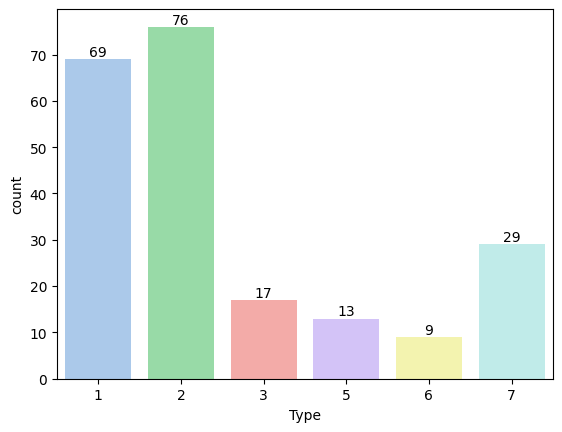

In [50]:
ax = sns.countplot(data=glass, x='Type')
ax.bar_label(ax.containers[0])

Checking for outliers in data

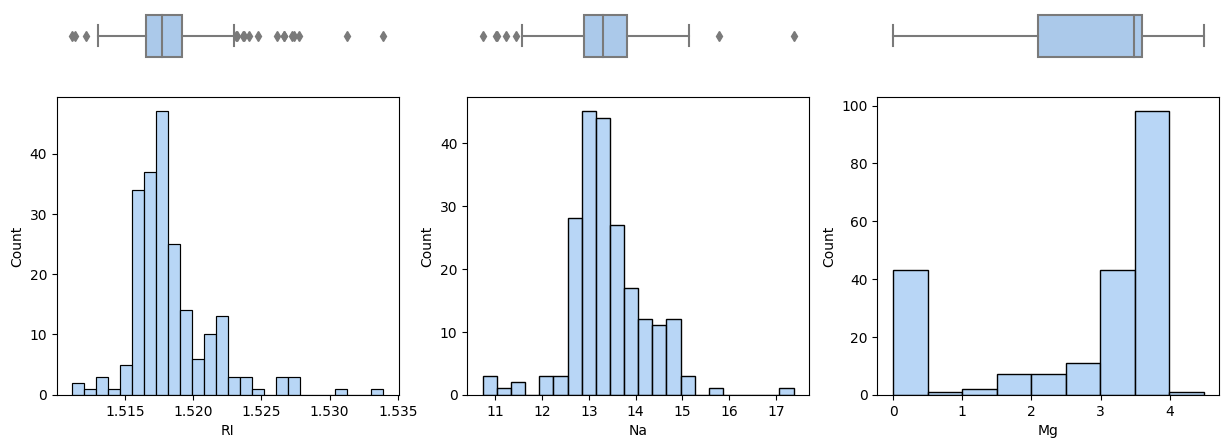

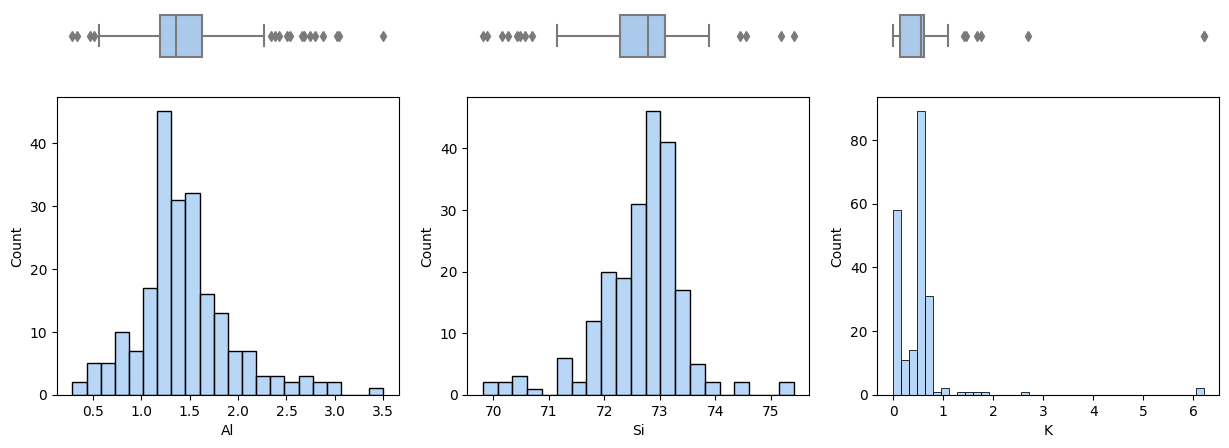

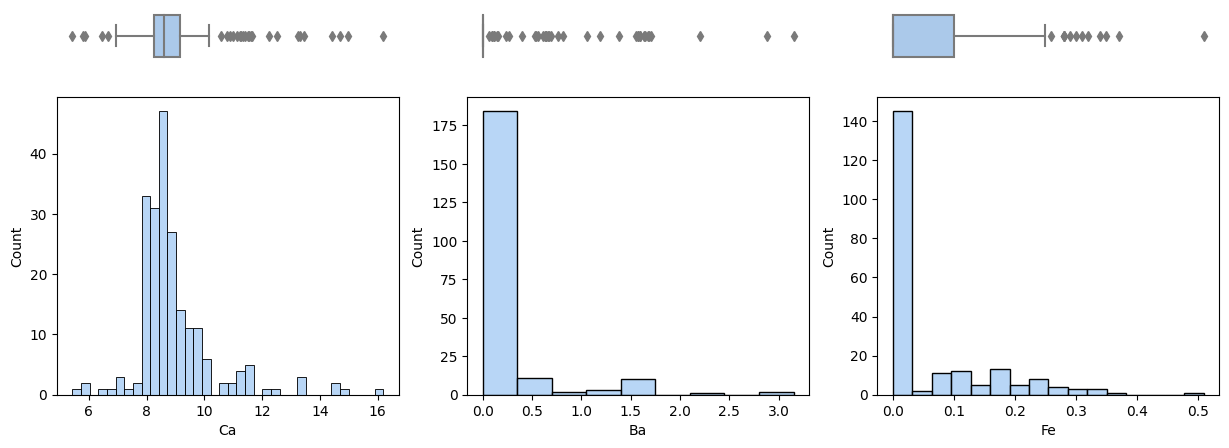

In [51]:
def plotboxhist(columns):
    figs, (box_axes, hist_axes) = plt.subplots(nrows=2,ncols=len(columns),figsize=(15,5),gridspec_kw={'height_ratios':(0.15,0.85)})
    for i in range(len(columns)):
        sns.boxplot(data=glass, x=columns[i], ax=box_axes[i])
        sns.histplot(data=glass, x=columns[i], ax=hist_axes[i])
        sns.despine(ax=box_axes[i], left=True, bottom=True)
        box_axes[i].set_xticks([])
        box_axes[i].set_yticks([])
        box_axes[i].set_xlabel('')

plotboxhist(['RI','Na','Mg'])
plotboxhist(['Al','Si','K'])
plotboxhist(['Ca','Ba','Fe'])


Removing outliers

In [52]:
glass.drop(glass[glass['RI']>1.530].index, axis=0, inplace=True)
glass.drop(glass[glass['Al']>3].index, axis=0, inplace=True)
glass.drop(glass[glass['K']>2].index, axis=0, inplace=True)
glass.drop(glass[glass['Ca']>14].index, axis=0, inplace=True)
glass.drop(glass[glass['Ba']>2.0].index, axis=0, inplace=True)
glass.drop(glass[glass['Fe']>0.4].index, axis=0, inplace=True)

In [53]:
glass.shape

(202, 10)

# Checking distributions again

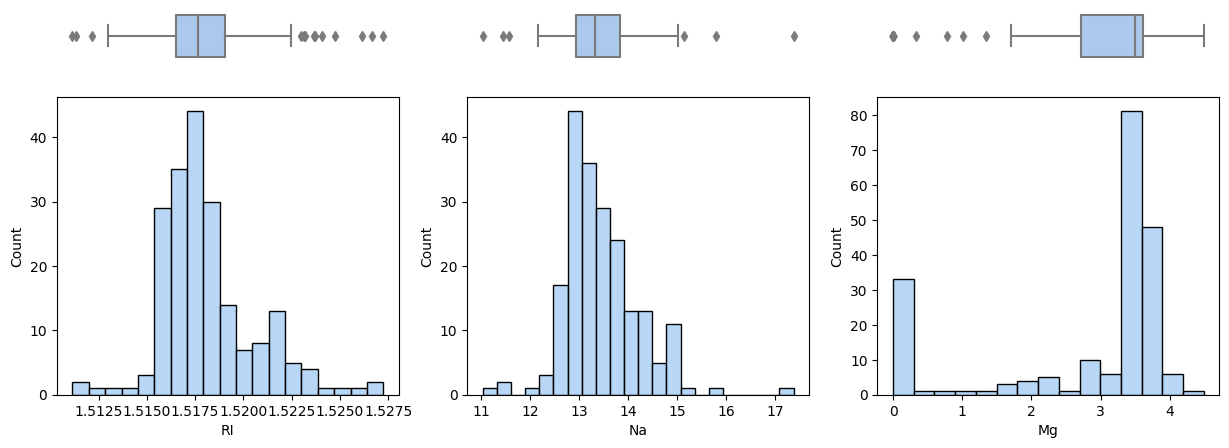

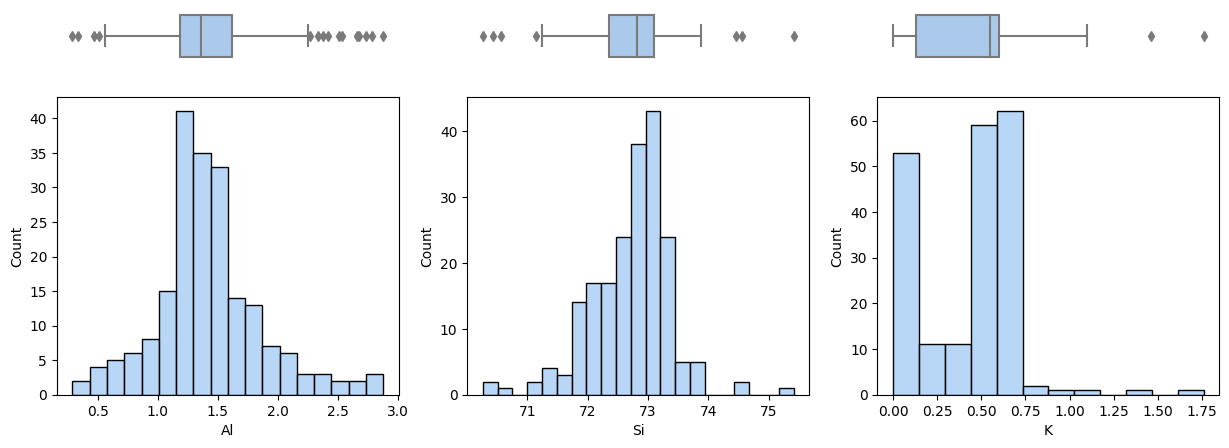

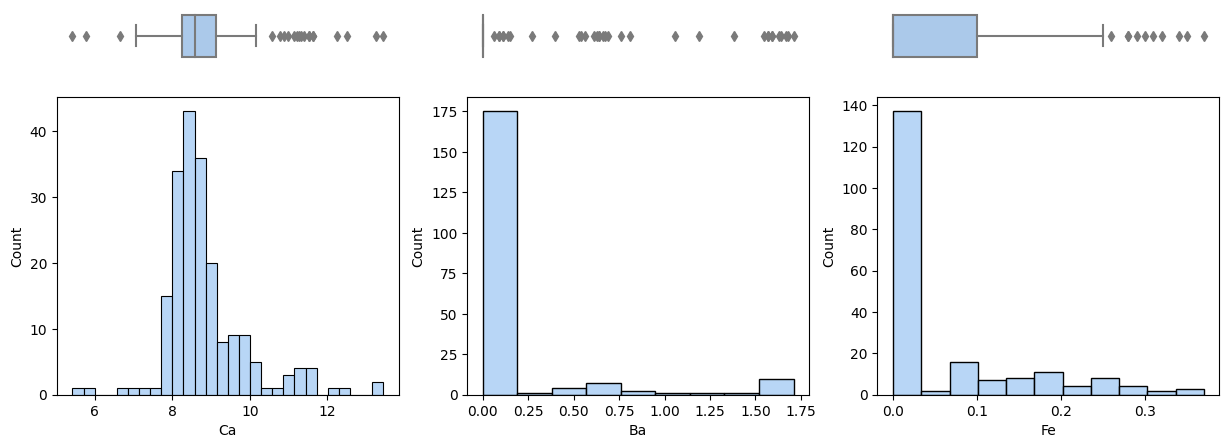

In [54]:
plotboxhist(['RI','Na','Mg'])
plotboxhist(['Al','Si','K'])
plotboxhist(['Ca','Ba','Fe'])

<Axes: >

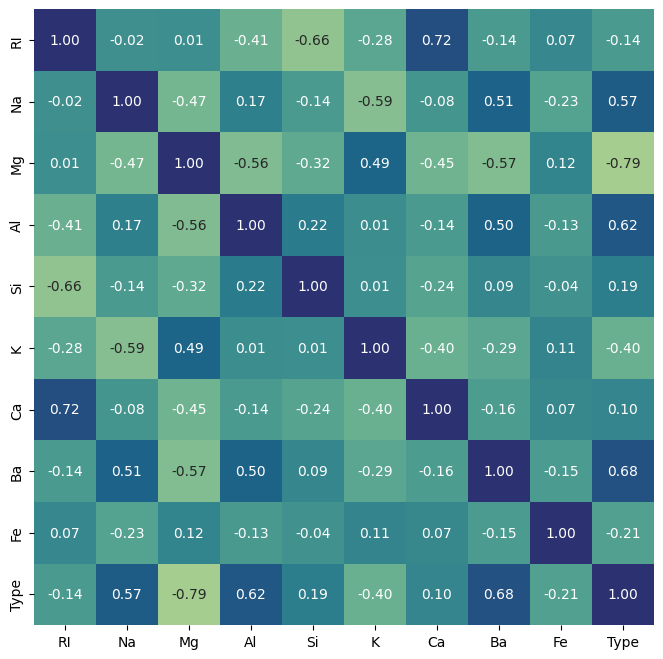

In [55]:
plt.figure(figsize=(8,8))
sns.heatmap(glass.corr(),annot=True,fmt='.2f',cbar=False,cmap='crest')

Preparing data for model

In [56]:
x = glass.drop('Type',axis=1)
y = glass['Type']

In [57]:
scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)

In [58]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.1,random_state=5)

**Parameter tuning**

##### Parameters in sklearn KNeighborsClassifier
**n_neighbors**
- default value is 5
- Number of neighbors to use by default for kneighbors queries.
- For our analysis we will check range of 1 to 40

**weights**
- default value is 'uniform'
- Weight function used in prediction.
- Possible values:
    - 'uniform': uniform weights. All points in each neighborhood are weighted equally.
    - 'distance': weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.
    - [callable]: user define function which accepts an array of distances, and returns an array of the same shape containing the weights.
- For our analysis we will check ['uniform','distance']

**algorithm**
- default value is 'auto'
- Algorithm used to compute the nearest neighbors
- Possible values:
    - 'ball_tree' will use BallTree: It partitions data into a series of nested bounding spheres
    - 'kd_tree' will use KDTree: It partitions the feature space so we can rule out whole partitions that are further away than our closest k neighbors.
    - 'brute' will use a brute-force search.
    - 'auto' will attempt to decide the most appropriate algorithm based on the values passed to fit method
- For our analysis we will go with default here.

**leaf_size**
- default value is 30
- Leaf size passed to BallTree or KDTree.
- This can affect the speed of the construction and query, as well as the memory required to store the tree. The optimal value depends on the nature of the problem.
- For our analysis we will go with default here.

**p**
- default value is 2
- Power parameter for the Minkowski metric.
- Possible values:
    - p = 1 is equivalent to using manhattan_distance (l1)
    - p=2 is euclidean_distance (l2)
    - For arbitrary p, minkowski_distance (l_p) is used
- For our analysis we will consider [1,2]

**metric**
- default value is 'minkowski'
- Metric to use for distance computation.
- Possible values:
    - 'manhattan': when power of minkowski distance is 1 (l1)
    - 'euclidean': when power of minkowski distance is 2 (l2)
    - 'chebyshev': when power of minkowski distance is infinity (l_inf)
    - 'minkowski': for arbitrary power of mikowski distance (l_p)
- For our analysis we will consider them all ['euclidean','manhattan','chebyshev','minkowski']

In [59]:
param_grid = {'n_neighbors':range(1,40),
              'weights':['uniform', 'distance'],
              'p': [1, 2],
              'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']}

In [60]:
model = KNeighborsClassifier()
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid.fit(x,y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'chebyshev',
                                    'minkowski'],
                         'n_neighbors': range(1, 40), 'p': [1, 2],
                         'weights': ['uniform', 'distance']})

In [61]:
print("Best parameters: ", grid.best_params_)
print("Best score: ", grid.best_score_)

Best parameters:  {'metric': 'manhattan', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Best score:  0.7124390243902439


Our best parameters are mostly default values,\
Note leaf_size and p are useless cause algorithm is auto and we are defining metric anyways.\
Only parameters need a specific mention are **{'metric':'manhattan','n_neighbors':5,'weights':'distance'}**

just to check trend of n_neighbors with different values, we will make a quick plot


Text(0, 0.5, 'Cross-Validated Accuracy')

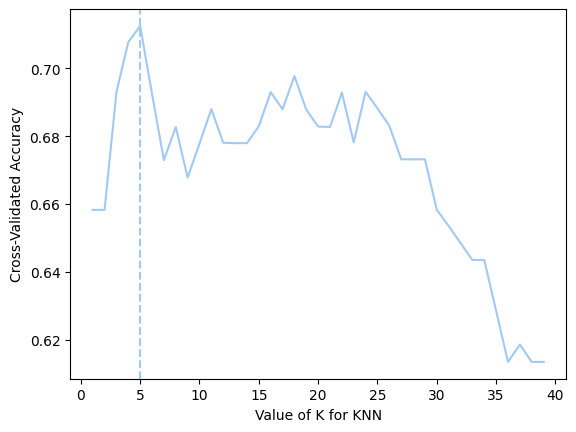

In [62]:
k_scores = []
for k in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=k,metric='manhattan',weights='distance')
    scores = cross_val_score(knn, x, y, cv=5)
    k_scores.append(scores.mean())

plt.plot(range(1,40), k_scores)
plt.axvline(x=5,linestyle='--')
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

Building model using best parameters

In [63]:
model = KNeighborsClassifier(n_neighbors=k,metric='manhattan',weights='distance')
results = cross_val_score(model, x, y, cv=5)

In [64]:
results.mean()*100

61.353658536585364

We got average of 95% accuracy in cross validation score

Building model on split data to check accuracy on unseen data

In [65]:
model = KNeighborsClassifier(n_neighbors=k,metric='manhattan',weights='distance')
model.fit(x_train,y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=39, weights='distance')

In [66]:
y_pred = model.predict(x_test)

In [67]:
np.mean(y_pred==y_test)*100

71.42857142857143

## We got 71 % acuuracy on unseen data